### Load models


In [9]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [10]:
device = torch.device("cuda:0")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}
dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "svhn": svhn, "mnist": mnist, "lsun": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 256
dataset = "cifar10"
ood_dataset = "svhn"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run17/vgg16_sn_3.0_mod_seed_1/2024_05_27_17_51_26/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=batch_size)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=batch_size)

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


In [11]:
#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
net.eval()

load ../saved_models/run17/resnet50_sn_3.0_mod_seed_1/2024_05_21_12_30_21/resnet50_sn_3.0_mod_seed_1_best.model


ResNet(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (shortcut): Sequential(
        (0): AvgPoolShortCut()
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_density(results, binrange, bins, title, xlabel, label1="org", label2="ood"):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0], density=True, color='r', range=binrange, bins=bins, alpha=0.5, label=label1)
    plt.hist(results[1], density=True, color='b', range=binrange, bins=bins, alpha=0.5, label=label2)

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()


if not os.path.exists(f"pngs/{model}"):
    os.makedirs(f"pngs/{model}")

In [13]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=512,
    augment=True,
    val_seed=1,
    val_size=0.1,
)
embeddings, labels, norm = get_embeddings(
    net,
    train_loader,
    num_dim=model_to_num_dim[model],
    dtype=torch.double,
    device=device,
    storage_device=device,
)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

get embeddings from dataloader...


100%|██████████| 88/88 [00:45<00:00,  1.94it/s]


norm threshold:22.452842712402344


### GradNorm wrt Input


In [14]:
def calculate_gradients_norm(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    wrt="input",
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):
    layer_grad = None

    def bp_hook(module, grad_input, grad_output):
        # 获取中间层梯度信息
        nonlocal layer_grad
        input_grad = grad_input[0]
        w_grad = grad_input[1]
        # input_grad = grad_input[2]#TODO: 当使用sn时，conv层的bias都为false，这时候这样的,当bias为true时候，需要再次验证???
        if wrt == "input":
            layer_grad = torch.norm(input_grad, p=norm)  #1-norm
        elif wrt == "weight":
            layer_grad = torch.norm(w_grad, p=norm)  #1-norm

    norms = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    start = 0
    if layer_name in ["image"]:
        handler = net.conv1.register_backward_hook(bp_hook)
    elif layer_name in ['layer1', 'layer2', 'layer3']:
        handler = getattr(net, layer_name)[0].conv1.register_backward_hook(bp_hook)
    elif layer_name in ['fc']:
        handler = getattr(net, layer_name).register_backward_hook(bp_hook)
    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)
        uniform = torch.ones_like(out).to(device)
        _, pred = torch.max(out, 1)

        # #1. 第一种形式loss,log_density
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        # loss = loss_func(out, pred)
        
        net.zero_grad()
        loss.backward()

        norms.append(layer_grad.cpu().detach())

        cnt+=data.shape[0]
        if cnt>1000:
            break
    
    return torch.tensor(norms)

100%|██████████| 1000/1000 [01:11<00:00, 13.94it/s]


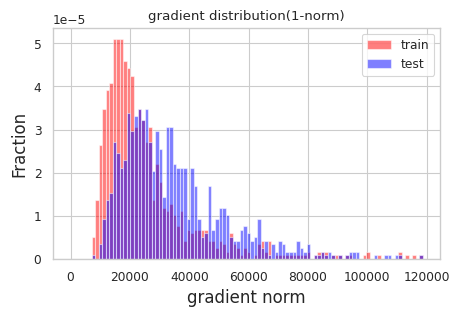

In [15]:
layer = "image"
wrt = "input"
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=1,
    augment=True,
    val_seed=1,
    val_size=0.1,
)
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
train_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    train_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), train_gradient_norms.quantile(0.99).item()))
#对比训练集和测试集的分布
plot_density([train_gradient_norms.numpy(), gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title="gradient distribution(1-norm)",
             xlabel="gradient norm",
             label1="train",
             label2="test")
plt.savefig(f'pngs/{model}/train_test_grad_wrt_input_dist.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:11<00:00, 13.95it/s]


grad norm for image:m2_auroc:0.9395069999999999,m2_auprc:0.9343137778265584


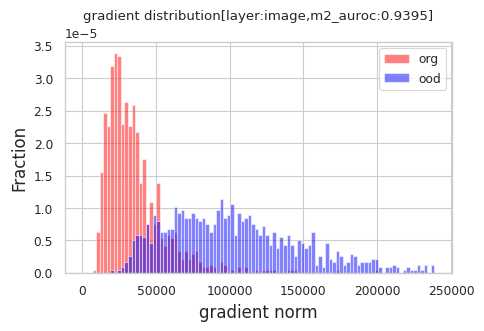

In [16]:
layer = "image"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[layer:{layer},m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]


grad norm for layer1:m2_auroc:0.9192829999999999,m2_auprc:0.9115682221626057


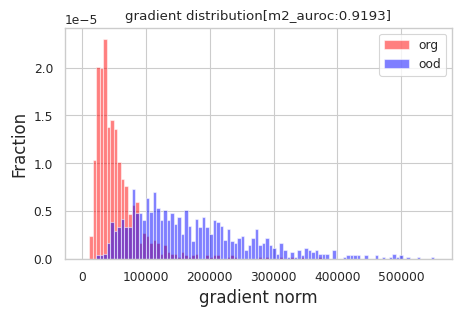

In [17]:
layer = "layer1"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]


grad norm for layer2:m2_auroc:0.912047,m2_auprc:0.8935904791574603


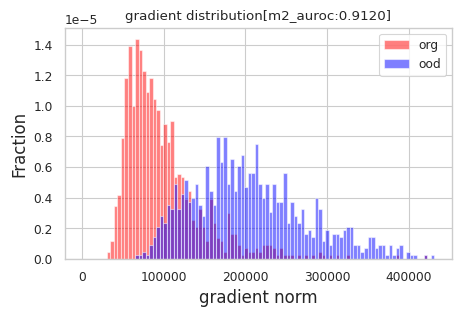

In [18]:
layer = "layer2"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]


grad norm for layer3:m2_auroc:0.8253329999999999,m2_auprc:0.7629166962565443


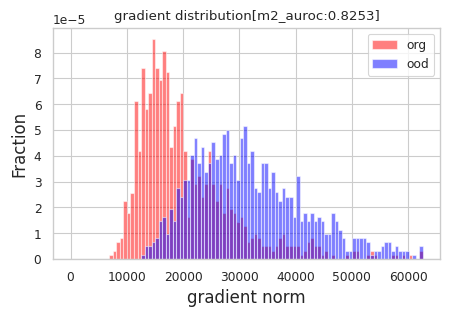

In [19]:
layer = "layer3"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

### GradNorm wrt Weight


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:11<00:00, 13.99it/s]


grad norm for image:m2_auroc:0.8612690000000001,m2_auprc:0.8061651403104415


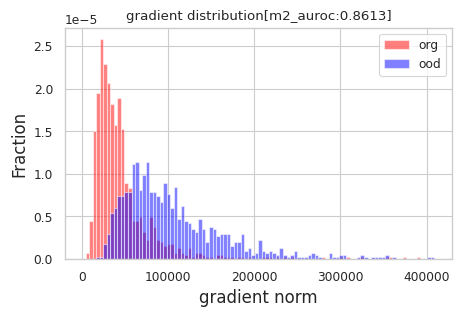

In [20]:
layer = "image"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_weight_dist.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]


grad norm for layer1:m2_auroc:0.918761,m2_auprc:0.9100828731289946


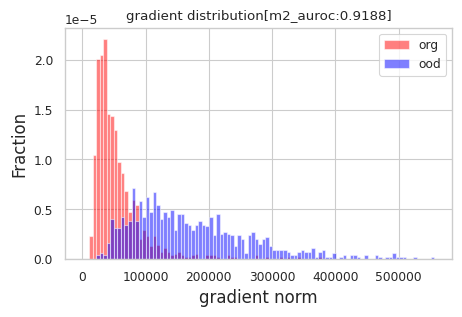

In [21]:
layer = "layer1"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_weight.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:12<00:00, 13.89it/s]


grad norm for layer2:m2_auroc:0.912259,m2_auprc:0.8942016018719675


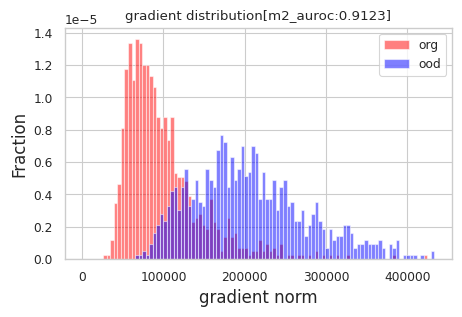

In [22]:
layer = "layer2"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_weight.png', bbox_inches='tight')

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


grad norm for layer3:m2_auroc:0.871333,m2_auprc:0.8507320904229688


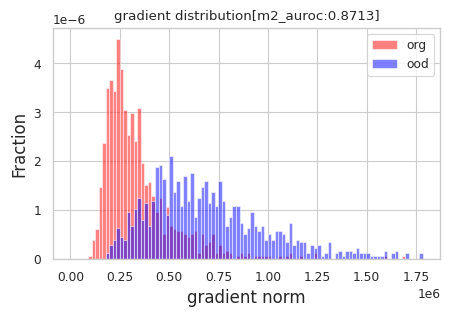

In [23]:
layer = "layer3"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_weight.png', bbox_inches='tight')